In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "---" # username from the json file
os.environ['KAGGLE_KEY'] = "---" # Provide your key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle

 99% 538M/543M [00:03<00:00, 184MB/s]
100% 543M/543M [00:03<00:00, 174MB/s]
 95% 258M/271M [00:01<00:00, 176MB/s]
100% 271M/271M [00:01<00:00, 160MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 87.3MB/s]


In [2]:
# Upload data and extract the contents
from zipfile import ZipFile

file_name = "/content/train.zip"    ##extract my training data

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
import pandas as pd
import numpy as np
import os


In [4]:
categories=[]   ####use to create label


filenames=os.listdir('/content/train') 
for img in filenames:
    if img.startswith('dog'):
        categories.append('dog')
        
    else:
        categories.append('cat') 
        
        
df=pd.DataFrame({'data':filenames,
                 'category':categories})
     
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 1000, stratify=df['category'])

In [5]:
####use generator to load the data batch to reduce RAM usage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50
#from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions,preprocess_input
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Sequential   #to create sequence of layer action
from tensorflow.keras.layers import  Dense, Flatten, Activation,  Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import categorical_accuracy

In [6]:
#initialize image generator and include preprocessing arcitecture to use
datagen = ImageDataGenerator(
    # define the preprocessing function that should be applied to all images based on
    #on pretrained archtecture
    preprocessing_function=resnet50.preprocess_input,
    validation_split=0.25,
    shear_range=0.2
)



train=datagen.flow_from_dataframe(train_df,
                                  directory='/content/train',
                                  x_col='data',  ###column with name of image
                                  y_col='category', ##column with label in string
                                  subset='training',  ##important for the model
                                  class_mode='categorical',
                                  shuffle=True,
                                  target_size=(224, 224), ##resize all image to the specified size
                                  batch_size=32 ##run the image 30 at once
                                 )


val=datagen.flow_from_dataframe(train_df,
                                directory='/content/train',
                                x_col='data',  ###column with name of image
                                y_col='category', ##column with label in string
                                subset='validation',
                                class_mode='categorical',
                                shuffle=True,
                                target_size=(224, 224), ##resize all image to the specified size
                                batch_size=32 ##run the image 30 at once
                                 )

###load test data
test_datagen=ImageDataGenerator(rescale=1./255.)
test=test_datagen.flow_from_dataframe(test_df,
                                  directory='/content/train',
                                  x_col='data',  ###column with name of image
                                  y_col=None, ##column with label in string
                                  shuffle=False,
                                  class_mode=None, ##we only need the x_colume for prediction
                                  target_size=(224, 224), ##resize all image to the specified size
                                  batch_size=32 ##run the image 30 at once
                                 )

Found 18000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


In [7]:
#initialise CNN architecture base (ResNet50)
K.clear_session()   #always start your NN session with it
base_model = resnet50.ResNet50(
    weights='imagenet', ##database of images 
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # to remove the dense layer of the import layer 
    input_shape=(224, 224, 3)
)

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
#freeze weight of base model, for the model not to learn new weight
base_model.trainable = False  

In [9]:
#add  personalized dense layer on the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
##compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=binary_crossentropy,
              metrics=[categorical_accuracy])



In [11]:
##fit model
# observe the validation loss and stop when it does not improve after 3 iterations
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    x=train,
    epochs=3,  #3 iterations
    verbose=2,
    callbacks=callback,
    #steps_per_epoch=train.n//train.batch_size,  ##based on length of train
    validation_data=val,
    #validation_steps=val.n//val.batch_size  ##num of steps for vaidatn iteration
)  

Epoch 1/3
563/563 - 393s - loss: 0.0684 - categorical_accuracy: 0.9777 - val_loss: 0.0334 - val_categorical_accuracy: 0.9870 - 393s/epoch - 698ms/step
Epoch 2/3
563/563 - 372s - loss: 0.0387 - categorical_accuracy: 0.9865 - val_loss: 0.0301 - val_categorical_accuracy: 0.9888 - 372s/epoch - 661ms/step
Epoch 3/3
563/563 - 357s - loss: 0.0341 - categorical_accuracy: 0.9877 - val_loss: 0.0277 - val_categorical_accuracy: 0.9895 - 357s/epoch - 635ms/step


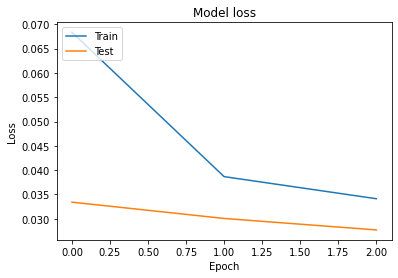

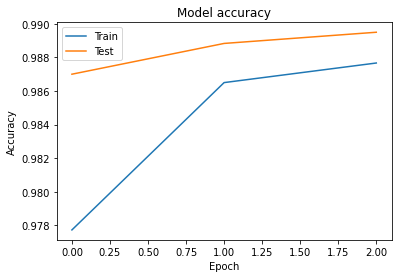

In [12]:
#evaluate model using the learningcurve
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

#Accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
score_train=model.evaluate(train)
print('Test loss:', score_train[0])
print('Test accuracy:', score_train[1])

563/563 [==============================] - 278s 494ms/step - loss: 0.0194 - categorical_accuracy: 0.9931
Test loss: 0.019394734874367714
Test accuracy: 0.9931111335754395


In [14]:
##evaluate model performance
score=model.evaluate(val)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

188/188 [==============================] - 90s 480ms/step - loss: 0.0277 - categorical_accuracy: 0.9890
Test loss: 0.027688905596733093
Test accuracy: 0.9890000224113464


In [17]:
##predict on test data
pred=model.predict(test)

In [18]:
y_pred=np.argmax(pred, axis=1)